<h1>"The Battle of Neighborhoods"</h1>
<h3>Coursera "IBM Data Science Professional Certificate" specialization capstone project</h3>


by _Leandro Oliveira Bortot_<br>
Prospective Data Scientist

<hr>

Contents:

<a href='#1'>1. Business Problem</a><br>
<a href='#2'>2. Data</a><br>
<a href='#3'>3. Methodology</a><br>
<a href='#4'>4. Results</a><br>
<a href='#5'>5. Discussion</a><br>
<a href='#6'>6. Conclusion</a>

<hr>

<a name='1'><h2>1. Business Problem</h2></a>

<b>1.1. Problem definition:</b><br>
The process of finding a new house or apartment when moving can be lengthy and, specially when moving to a different city, costly due to several travels to the new city to visit potential new houses indicated by the real estate companies.<br>
In this notebook we propose a way of shortening this process by using data about the most popular venues of each neighborhood of a given city to find their "venue profile".

<br>

<b>1.2. Target audience:</b><br>
Analyzes like the one we will present here may be useful to real estate companies. They can make a short interview, or use a web-based form, to determine what is the "venue profile" that each client prefers and them suggest houses located in neighborhoods with "venues profile" that matches the client's preferences.<br>
Accelerating the process of matching clients with houses with which they will be satisfied benefits both sides: It is beneficial to the real estate company because it increases the chances of closing deals before its competitors and to the client because it saves their time and money due to less visits to houses suggested by the real estate company in which they don't really have interest.<br><br>
The analysis we will show here is general and can be applied to any city. In this notebook, we will use the city of Ribeirão Preto, one of the largest of the State of São Paulo, Brazil.

<a name='2'><h2>2. Data</h2></a>
In order to tackle the problem of defining the "venue profiles" of neighborhoods in a city, we will use:<br>

<b>2.1. Web scraping with BeautifulSoup to obtain a list of all neighborhoods of Ribeirão Preto (SP-Brazil).</b><br>
This will be done via the following link: https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Ribeir%C3%A3o_Preto

<b>2.2. Google Maps API for geocoding the neighborhood names into their coordinates.</b><br>
This can be done by a POST request in the following form:<br><br>
`https://maps.googleapis.com/maps/api/geocode/json?key=YOUR_API_KEY&address=Centro,+Ribeirão+Preto,+São Paulo,+Brazil`<br><br>
Which returns a JSON file with the following form:<br>
<img src='geocoding_example.png' width='400'><br>
In this case, the central neighborhood of Ribeirão Preto was successfully geocoded to coordinates -21.1704008 , -47.8103238

<b>2.3. Foursquare API to get all venues in each neighborhood.</b><br>
Popular venues near a given coordinate can be obtained from the Foursquare API by a POST request with the following form:<br><br>
`https://api.foursquare.com/v2/venues/search?client_id=YOUR_ID&client_secret=YOUR_SECRET&v=VERSION&ll=-21.1704008,-47.8103238&radius=1000&limit=9999&intent=browse`<br><br>
Which returns a JSON file like this:<br>
<img src='foursquare_example.png' width='400'><br>
It is possible to extract the venues categories from this JSON file. Venues categories will be used to determine clusters of neighborhood with the same "venue profile" in the modeling step.<br>
Note that while in the Lab assignments we used the _explore_ endpoint, the analysis here will use the _search_ endpoint with the parameter _intent=browse_. This returns all venues in a given area regardless of their popularity at the moment the query is made.  



<a name='3'><h2>3. Methodology section</h2></a>

The methods used in this work were:
1. Web Scraping with the BeautifulSoup library
2. Geocoding with the Google Maps API
3. Data acquisition from Foursquare's API
4. Feature reduction by considering most common venue categories
5. Machine learning: k-Means clustering because it is the most simple clustering algorithm and it was capable of meeting the proposed objective

<a name='4'><h2>4. Results</h2></a>

<h3>Web scraping</h3>


There is a Wikipedia page in which all neighborhoods of Ribeirão Preto are listed in its index/table of contents, like this:<br>

<img src="wiki_bairros.png" width="400">

The following function uses BeautifulSoup to scrape a Wikipedia page and extract the elements of its index/table of contents. It returns a list with the text for each element.<br>
The "level" parameter is the level of the elements we are interested in a nested list. For example, if level=1 we will ignore items such as 1.3, 2.3.1 etc. If level=2 we will only extract items such as 1.2, 2.4 etc.

In [1]:
def scrape_wiki_index( url , level=1 ):
    request = requests.get(url)
    html_doc = request.text
    soup = BeautifulSoup( html_doc , 'html.parser')

    spans_txt = soup.find_all('span', {'class' : 'toctext'})
    spans_num = soup.find_all('span', {'class' : 'tocnumber'})

    list_txt = [txt.get_text() for txt in spans_txt]
    list_num = [num.get_text() for num in spans_num]

    list_all = list(zip(list_num,list_txt))

    list_index = [ element[1] for element in list_all if len(element[0].split('.'))==level]
    
    return list_index


In [2]:
from   bs4      import BeautifulSoup
import requests # library to handle requests

neighborhoods = scrape_wiki_index('https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Ribeir%C3%A3o_Preto',1)
total_neighborhoods = len(neighborhoods)

print('Sucessfully scraped a total of %d neighborhoods' % total_neighborhoods)
neighborhoods[0:10]

Sucessfully scraped a total of 234 neighborhoods


['Campos Elíseos',
 'Vila Gertrudes',
 'Vila Carvalho',
 'Vila Albertina',
 'Vila Augusta',
 'Vila Esperança',
 'José Sampaio',
 'Jardim Procópio',
 'Parque das Figueiras',
 'Jardim Alexandre Balbo']

We sucessfully scraped all 234 lines of the Wikipedia page's index/table of contents.
However, some neighborhoods appear more than once because they span more than one "city zone".

Let's remove the duplicates:

In [4]:
neighborhoods = list(set(neighborhoods))
neighborhoods.sort()

total_neighborhoods = len(neighborhoods)

print('We have %d unique neighborhoods' % total_neighborhoods)

We have 229 unique neighborhoods


We sucessfully scraped the information we need.

<h3>Geocoding</h3>
Now, we need to obtain the coordinates of each neighborhood.<br>
This will be done with the geocoding feature of the Google Maps API with the follwing function:

In [3]:
def geocode(key,address):
    url='https://maps.googleapis.com/maps/api/geocode/json?key='+key+'&address='+address

    tmp = requests.get(url).json()['results'][0]['geometry']['location']
    
    latitude  = tmp['lat']
    longitude = tmp['lng']
    
    return latitude , longitude

In [4]:
# Reads the Google Maps API key from a local file in order to avoid exposing my credentials in this notebook
with open('GoogleMapsAPI_key.dat','r') as inputfile:
    maps_api_key = inputfile.read()

In [6]:
import json
import pandas as pd

# Creating an empty dictionary in which the coordinates for each neighborhoods will be stored
info={}

n=1
for neighborhood in neighborhoods:
    print('Geocoding neighborhood %3d of %3d ... ' % (n,total_neighborhoods) , end='')
    
    info[neighborhood]={}
    
    address = neighborhood+', Ribeirão Preto, SP, Brazil'
    
    lat,lon = geocode( maps_api_key , address )
    
    info[neighborhood]['Latitude']  = lat
    info[neighborhood]['Longitude'] = lon
    
    print('%.6f , %6f' % (lat,lon) )
    
    n += 1
    

# Converts the dictionary to a pandas dataframe
df_coord = pd.DataFrame.from_dict(info)
df_coord = df_coord.transpose()

# Saves the coordinates locally to avoid too many queries to the Google Maps API during development
df_coord.to_csv( 'rp_coordinates.csv'  )

display( df_coord.head(10) )
print( df_coord.shape )

Geocoding neighborhood 1 of 234
Geocoding neighborhood 2 of 234
Geocoding neighborhood 3 of 234
Geocoding neighborhood 4 of 234
Geocoding neighborhood 5 of 234
Geocoding neighborhood 6 of 234
Geocoding neighborhood 7 of 234
Geocoding neighborhood 8 of 234
Geocoding neighborhood 9 of 234
Geocoding neighborhood 10 of 234
Geocoding neighborhood 11 of 234
Geocoding neighborhood 12 of 234
Geocoding neighborhood 13 of 234
Geocoding neighborhood 14 of 234
Geocoding neighborhood 15 of 234
Geocoding neighborhood 16 of 234
Geocoding neighborhood 17 of 234
Geocoding neighborhood 18 of 234
Geocoding neighborhood 19 of 234
Geocoding neighborhood 20 of 234
Geocoding neighborhood 21 of 234
Geocoding neighborhood 22 of 234
Geocoding neighborhood 23 of 234
Geocoding neighborhood 24 of 234
Geocoding neighborhood 25 of 234
Geocoding neighborhood 26 of 234
Geocoding neighborhood 27 of 234
Geocoding neighborhood 28 of 234
Geocoding neighborhood 29 of 234
Geocoding neighborhood 30 of 234
Geocoding neighborh

,Latitude,Longitude
Campos Elíseos,-21.162380,-47.798293
Vila Gertrudes,-23.621491,-46.696494
Vila Carvalho,-21.142448,-47.792124
Vila Albertina,-21.150803,-47.815570
Vila Augusta,-21.140195,-47.821237
Vila Esperança,-21.154167,-47.770728
José Sampaio,-21.138542,-47.826679
Jardim Procópio,-21.133577,-47.834086
Parque das Figueiras,-21.130052,-47.838307
Jardim Alexandre Balbo,-21.129665,-47.829148


(229, 2)


We geocoded all 229 neighborhoods, but are the coordinates accurate?<br>
Let's check this by visualizing the neighborhoods in a map with the following functions:

In [16]:
# Creates the basemap centered at (lat,lng) and returns a map object
def map_define( center_lat , center_lng , zoom=12):
    map_rp_fig = folium.Figure(width=600,height=600)
    map_rp = folium.Map( location=[center_lat,center_lng], zoom_start=zoom, tiles="OpenStreetMap")
    map_rp.add_to(map_rp_fig)
    
    return map_rp


# Adds circular markers to a map object (folium_map). The locations and labels are taken from lists
def map_markers( folium_map , lat_list , lng_list , label_list , color , radius ):
    for lat,lng,label in zip(lat_list,lng_list,label_list):
        folium.features.CircleMarker(location=[lat,lng],
                                     popup=str(label.replace('\'','_').replace('\\','_').replace('/','_').replace(':','_')),
                                     color=color,
                                     fill=True,
                                     fill_color=color,
                                     fill_opacity=0.75,
                                     radius=radius).add_to(folium_map)
    return folium_map

In [17]:
# Gets the coordinates for the city
lat_rp,lon_rp = geocode( maps_api_key , 'Ribeirão Preto, SP, Brazil' )

In [18]:
import folium

mapa = map_define( lat_rp , lon_rp , zoom=5)
mapa = map_markers( mapa , df_coord['Latitude'] , df_coord['Longitude'] , df_coord.index.values, 'red' , 2 )
mapa

By exploring the map we can see that 6 neighborhoods were incorrectly geocoded. They are:

- Jardim Botuporã
- Jardim Ibirapuera
- Jardim Aclimação
- Bosque dos Jequitibás
- Jardim Santa Genebra
- Jardim Jamaica

I couldn't find information about these neighborhoods even at the official city website. They were probably old neighborhoods that had their names changed over time.<br>
Interestingly, Google Maps pointed to other cities with the same neighborhood names.<br>
So we will drop these neighborhoods from our dataframe.<br>

In [19]:
incorrect_list = ['Jardim Botuporã','Jardim Ibirapuera','Jardim Aclimação','Bosque dos Jequitibás','Jardim Santa Genebra','Jardim Jamaica']

df_coord.drop( incorrect_list , inplace=True, axis=0)

total_neighborhoods = df_coord.shape[0]

print('We now have %d unique neighborhoods' % total_neighborhoods )

We now have 223 unique neighborhoods


<h3>Getting venue information</h3>

Finally, we will get data about venues around each neighborhood using the Foursquare API:

In [20]:
# Reads the Foursquare API key from a local file in order to avoid exposing my credentials in this notebook
with open('FoursquareAPI_secret.dat','r') as inputfile:
    foursquare_api_key = inputfile.read()

In [23]:
# Gets all venues (not just the popular ones!) around the coordinates (`latitude`,`longitude`).
# Returns a list of venues. Each venue is a tuple in the format (venue_name, venue_category, venue_latitude, venue_longitude)
def foursquare_get_venues_around( secret, latitude , longitude , neighborhood ):

    foursquare_id      = 'X23432AINNXT522Z1335TOP1UBCVX0HDXHQWVASBXVTC3MLI'
    foursquare_secret  = secret
    foursquare_version = '20190129'
    radius             = 300
    limit              = 99999

    foursquare_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent=browse'.format(
        foursquare_id,
        foursquare_secret,
        foursquare_version,
        latitude,
        longitude,
        radius,
        limit
    )
    
    results = requests.get(foursquare_url).json()['response']['venues']
    
    
#    with open("rp_search.json", "w") as outfile:
#        json.dump(results, fp=outfile)
    
    number_of_venues = len(results)

    venues = []
    
    for n in range(0,number_of_venues):
        try:
            venue_category   = results[n]['categories'][0]['name']
        except:
            venue_category = 'MISSING'
        venue_name       = results[n]['name']
        venue_latitude   = results[n]['location']['lat']
        venue_longitude  = results[n]['location']['lng']

        venues.append( (venue_name, venue_category, venue_latitude, venue_longitude, neighborhood ) )
    
    return(venues)

In [27]:
# Empty list that will hold information about all venues
venues = []

n=1
for latitude,longitude,neighborhood in zip(df_coord['Latitude'],df_coord['Longitude'],df_coord.index):
    
    print('Getting venue info for neighborhood %3d of %3d... ' % (n,total_neighborhoods) , end='')
    
    venues_new =  foursquare_get_venues_around( foursquare_api_key , latitude , longitude , neighborhood ) 
    
    venues += venues_new
    
    print('%d venues found.' % len(venues_new))
    n+=1

# Convert the list with venue information to a dataframe
df_venues = pd.DataFrame.from_records(venues , columns=['Venue Name','Venue Category','Latitude','Longitude','Neighborhood'] )

# Save the dataframe to avoid making too many requests to the API during development
df_venues.to_csv( 'rp_venues.csv' )

Getting venue info for neighborhood 1 of 223... 185 venues found.
Getting venue info for neighborhood 2 of 223... 175 venues found.
Getting venue info for neighborhood 3 of 223... 121 venues found.
Getting venue info for neighborhood 4 of 223... 190 venues found.
Getting venue info for neighborhood 5 of 223... 105 venues found.
Getting venue info for neighborhood 6 of 223... 133 venues found.
Getting venue info for neighborhood 7 of 223... 132 venues found.
Getting venue info for neighborhood 8 of 223... 125 venues found.
Getting venue info for neighborhood 9 of 223... 164 venues found.
Getting venue info for neighborhood 10 of 223... 111 venues found.
Getting venue info for neighborhood 11 of 223... 137 venues found.
Getting venue info for neighborhood 12 of 223... 117 venues found.
Getting venue info for neighborhood 13 of 223... 110 venues found.
Getting venue info for neighborhood 14 of 223... 110 venues found.
Getting venue info for neighborhood 15 of 223... 106 venues found.
Gett

In [31]:
print(df_venues.shape)

display(df_venues.head(10))
display(df_venues.tail(10))

(30090, 5)


,Venue Name,Venue Category,Latitude,Longitude,Neighborhood
0,Salgaderia 2 irmãos,Snack Place,-21.161945,-47.798283,Campos Elíseos
1,Esquina Do Sr. Olívio Salgaderia,Snack Place,-21.161947,-47.797994,Campos Elíseos
2,Pinguim Frios,MISSING,-21.163100,-47.797900,Campos Elíseos
3,Alex Cabeleireiro,Salon / Barbershop,-21.162427,-47.797245,Campos Elíseos
4,AGN CONSTRUÇÕES LTDA - RIBEIRÃO PRETO,Office,-21.163195,-47.798478,Campos Elíseos
5,Congregação Crista no Brasil (central),Non-Profit,-21.161597,-47.799066,Campos Elíseos
6,xapuri,Brazilian Restaurant,-21.162982,-47.797731,Campos Elíseos
7,Clinica Integral,Dentist's Office,-21.163759,-47.798519,Campos Elíseos
8,Aurora Festas,General Entertainment,-21.163899,-47.797780,Campos Elíseos
9,Posto Beta News,Gas Station,-21.163554,-47.797596,Campos Elíseos


,Venue Name,Venue Category,Latitude,Longitude,Neighborhood
30080,Antonia Store,Women's Store,-21.266308,-47.816792,Recanto das Flores
30081,Loja ANTÔNIA,Women's Store,-21.266278,-47.816931,Recanto das Flores
30082,Ponto De Encontro,Restaurant,-21.265534,-47.818270,Recanto das Flores
30083,Cervejaria Walfänger,Brewery,-21.262733,-47.819446,Recanto das Flores
30084,Quitanda César,Deli / Bodega,-21.259098,-47.814017,Recanto das Flores
30085,Alpha Instrumentos,Health & Beauty Service,-21.262761,-47.817134,Recanto das Flores
30086,Comunidade Nova Geração,Non-Profit,-21.289214,-47.812672,Recanto das Flores
30087,Feira de Bonfim,Farmers Market,-21.258972,-47.814057,Recanto das Flores
30088,Recanto Caipira,Comfort Food Restaurant,-21.268431,-47.815307,Recanto das Flores
30089,Sítio Manga Rosa,Garden Center,-21.288823,-47.812413,Recanto das Flores


There are some venues for which no category was assigned. In this case, the category field is filled with "MISSING".<br>
Let's drop all venues for which the category is missing.

In [32]:
print('Shape before =', df_venues.shape )

missing_vector = df_venues['Venue Category']=='MISSING'

print('Venues without an assigned category = %d' % missing_vector.sum() )

df_venues = df_venues[ ~missing_vector ]

print('Shape after=', df_venues.shape)


Shape before:  (30090, 5)
638 venues have no category and will be dropped.
Shape after:  (29452, 5)


How are the categories distributed among the venues?

In [297]:
df_tmp = pd.DataFrame(df_venues['Venue Category'].value_counts())
total_categories = df_tmp.shape[0]

print('Total number of categories =', total_categories)
display(df_tmp)

Total number of categories = 482


,Venue Category
Residential Building (Apartment / Condo),1774
General Entertainment,1450
Office,1198
Salon / Barbershop,1016
Automotive Shop,770
Factory,704
Church,625
Building,589
Bakery,506
Housing Development,464


We have more than 400 unique categories, but many of them have very few representative venues.<br>
These low-populated categories can act as noise in our feature space and make clustering harder. So we'll drop all categories which have less which venues represent less than 1% of the total number of venues.

In [329]:
#df_venues = df_venues_backup.copy()

print(df_venues.shape)

total_venues=df_tmp.sum()[0]

# Calculate the percentage of "venue occupancy" for each category
df_tmp['percentage'] = (df_tmp['Venue Category']/total_venues)*100

# We'll keep only the categories for which the "venue occupancy" is > 1%
mask_categories = df_tmp['perc']>0.5
df_filtered_categories = df_tmp[mask_categories]
list_kept_categories = list(df_filtered_categories.index)

# Creates a new empty dataframe
df_new = pd.DataFrame(columns=['Venue Name','Venue Category','Latitude','Longitude','Neighborhood'])


mask_venues = []
for category in list(df_venues['Venue Category']):
    mask_venues.append(category in list_kept_categories)

df_venues = df_venues[ mask_venues ]

print(df_venues.shape)

print('Now we are keeping %d categories.' % len(list_kept_categories))

(29452, 5)
(18022, 5)
Now we are keeping 45 categories.


Now we'll apply the one-hot encoding approach to the 'Venue category' field of all venues.

In [330]:
print('Shape of the original venues dataframe =', df_venues.shape)





# Creates a new dataframe with the one-hot encoding columns
df_onehot = pd.get_dummies(df_venues['Venue Category'])

# Adds a column with the name of the neighborhood for each venue
df_onehot['Neighborhood'] = df_venues['Neighborhood']

print('Shape of the one-hot encoding dataframe =', df_onehot.shape)





# Builds a new dataframe with the number of occurrences of each category for each neighborhood
# Here the zeros and ones of the one-hot encoding act as counters.
df_count = df_onehot.groupby('Neighborhood').sum()

# Adds a column with the total number of venues for each neighborhood
df_count['Total'] = df_count.sum(axis=1)

print('Shape of the counting dataframe =', df_count.shape)





# Builds a new dataframe with the frequency, in %, of each venue for each neighborhood
df_freq = df_count.copy()

for column in df_freq.columns:
    df_freq[column] = (df_freq[column]/df_freq['Total'])*100

df_freq.drop('Total', axis=1, inplace=True)

print('Shape of the frequency dataframe =', df_freq.shape)

Shape of the original venues dataframe = (18022, 5)
Shape of the one-hot encoding dataframe = (18022, 45)
Shape of the counting dataframe = (223, 45)
Shape of the frequency dataframe = (223, 44)


Now we have a dataframe with all information we need to proceed to the clustering step.

<h3>Clustering</h3>
Now we will use k-Means clustering in order to find "venue profiles" for the neighborhoods.<br>
First let's find the optimum value for k, which is the number of clusters.

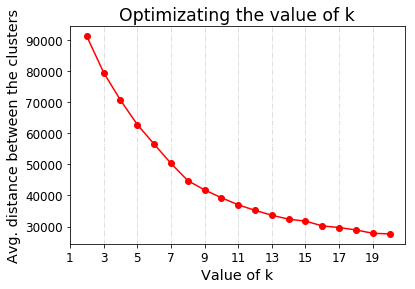

In [331]:
from   sklearn.cluster   import KMeans
import matplotlib.pyplot as plt

total_ks=20

ks    = []
perc  = []
score = []

for k in range(2,total_ks+1):
    kmeans = KMeans(n_clusters=k, random_state=809928).fit(df_freq)
    score.append(kmeans.inertia_)
    ks.append(k)
    
    df_clust = pd.DataFrame(df_freq.index.values)
    df_clust.columns = ['Neighborhood']
    df_clust['Cluster'] = kmeans.labels_

    df_clust_sizes = pd.DataFrame(df_clust['Cluster'].value_counts())
    df_clust_sizes.index.name = 'Cluster ID'
    df_clust_sizes.columns = ['Count']
    df_clust_sizes['Percentage'] = np.round((df_clust_sizes['Count']/df_clust_sizes['Count'].sum())*100 , 1)
    
    perc.append(df_clust_sizes['Percentage'].iloc[-1])


plt.plot(ks,score,'o-r')

plt.xticks(ticks=range(1,total_ks+1,2),fontsize='large')
plt.xlabel('Value of k',fontsize='x-large')

plt.yticks(fontsize='large')
plt.ylabel('Avg. distance between the clusters',fontsize='x-large')

plt.grid(which='major', alpha=0.5, axis='x', linestyle='-.')

plt.title('Optimizating the value of k',fontsize='xx-large')

plt.show()

If looks like we have an elbow point at k=8, so let's use it as the number of clusters.

In [333]:
k = 8
kmeans = KMeans(n_clusters=k, random_state=0).fit(df_freq)

In [334]:
# Creating a new dataframe with the neighborhood names
df_clust = pd.DataFrame(df_freq.index.values)
df_clust.columns = ['Neighborhood']

# Adding the cluster ID as a column of the dataframe
df_clust['Cluster'] = kmeans.labels_

display(df_clust.head(5))
print(df_clust.shape)

,Neighborhood,Cluster
0,Adão do Carmo Leonel,2
1,Alto da Boa Vista,5
2,Alto do Bonfim,2
3,Alto do Ipiranga,2
4,Antônio Marincek,2


(223, 2)


In [335]:
# Merge dataframes in order to fetch information about the coordinates of each neighborhood
df_coord.index.name='Neighborhood'

df_clust = pd.merge( df_clust , df_coord, on='Neighborhood', how='inner')

display(df_clust.head(5))
print(df_clust.shape)

,Neighborhood,Cluster,Latitude,Longitude
0,Adão do Carmo Leonel,2,-21.192685,-47.848287
1,Alto da Boa Vista,5,-21.198949,-47.815570
2,Alto do Bonfim,2,-21.266195,-47.810535
3,Alto do Ipiranga,2,-21.153740,-47.829148
4,Antônio Marincek,2,-21.125303,-47.806930


(223, 4)


We are ready to visualize how the clusters are spatially organized!

In [336]:
import numpy             as np
import matplotlib.cm     as cm
import matplotlib.colors as colors

map_clusters = map_define( lat_rp , lon_rp )

colors_array = cm.rainbow(np.linspace(0, 1, k))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for cl in range(0,k):
    tmp = df_clust[ df_clust['Cluster']==cl ]
    map_clusters = map_markers( map_clusters , tmp['Latitude'] , tmp['Longitude'] , [str(cl)]*tmp.shape[0], rainbow[cl] , 6 )

map_clusters

How are these clusters populated?

In [337]:
df_clust_sizes = pd.DataFrame(df_clust['Cluster'].value_counts())
df_clust_sizes.index.name = 'Cluster ID'
df_clust_sizes.columns = ['Count']
df_clust_sizes['Percentage'] = np.round((df_clust_sizes['Count']/df_clust_sizes['Count'].sum())*100 , 1)

display(df_clust_sizes)

,Count,Percentage
Cluster ID,,
2,112,50.2
3,30,13.5
1,24,10.8
0,18,8.1
7,13,5.8
5,13,5.8
4,9,4.0
6,4,1.8


We have clusters with very different sizes. From cluster 2 comprising 50% of all neighborhoods to cluster 6 comprising only 1.8 of all neighborhoods.<br>
How are the clusters different in terms of venue categories?

In [339]:
def normalize_column(df,column):
    return df[column]/df[column].sum()

for cluster in range(0,k):

    postcodes_cluster = df_clust[df_clust['Cluster']==cluster]['Neighborhood'].unique()
    
    cluster_size = len( df_clust[df_clust['Cluster']==cluster]['Neighborhood'] )
    cluster_size_perc = np.round( (cluster_size / df_clust['Cluster'].count())*100 , 1 )
    
    print('Profile of cluster with ID={}:'.format(cluster))
    print('  It has {} members ({}% of total venues)'.format( cluster_size,cluster_size_perc))
    
    tmp  = pd.DataFrame()
    tmp2 = pd.DataFrame()

    for postcode in postcodes_cluster:
        tmp[postcode]=df_freq.loc[postcode,]
    tmp2 = pd.DataFrame(tmp.transpose().mean().sort_values(ascending=False).head(3))
    tmp2.reset_index(inplace=True)
    tmp2.columns=['Venue Category','Venue Mean Frequency']
    tmp2['Venue Frequency in top-5'] = np.round(normalize_column(tmp2,'Venue Mean Frequency')*100,1)
    display(tmp2)

Profile of cluster with ID=0:
  It has 18 members (8.1% of total venues)


,Venue Category,Venue Mean Frequency,Venue Frequency in top-5
0,Factory,22.232403,53.1
1,Office,9.874897,23.6
2,General Entertainment,9.763974,23.3


Profile of cluster with ID=1:
  It has 24 members (10.8% of total venues)


,Venue Category,Venue Mean Frequency,Venue Frequency in top-5
0,General Entertainment,25.997680,70.1
1,Residential Building (Apartment / Condo),5.546969,15.0
2,Event Space,5.529759,14.9


Profile of cluster with ID=2:
  It has 112 members (50.2% of total venues)


,Venue Category,Venue Mean Frequency,Venue Frequency in top-5
0,Salon / Barbershop,8.357123,37.1
1,Residential Building (Apartment / Condo),7.214372,32.1
2,General Entertainment,6.934518,30.8


Profile of cluster with ID=3:
  It has 30 members (13.5% of total venues)


,Venue Category,Venue Mean Frequency,Venue Frequency in top-5
0,Residential Building (Apartment / Condo),33.746190,75.7
1,Office,5.538602,12.4
2,General Entertainment,5.281168,11.9


Profile of cluster with ID=4:
  It has 9 members (4.0% of total venues)


,Venue Category,Venue Mean Frequency,Venue Frequency in top-5
0,Office,31.215132,63.9
1,Building,10.422943,21.3
2,Coworking Space,7.229651,14.8


Profile of cluster with ID=5:
  It has 13 members (5.8% of total venues)


,Venue Category,Venue Mean Frequency,Venue Frequency in top-5
0,Doctor's Office,20.285994,51.2
1,Office,12.820722,32.3
2,Salon / Barbershop,6.540254,16.5


Profile of cluster with ID=6:
  It has 4 members (1.8% of total venues)


,Venue Category,Venue Mean Frequency,Venue Frequency in top-5
0,College Lab,43.281804,76.3
1,Hospital,8.771838,15.5
2,Student Center,4.676968,8.2


Profile of cluster with ID=7:
  It has 13 members (5.8% of total venues)


,Venue Category,Venue Mean Frequency,Venue Frequency in top-5
0,Automotive Shop,22.233066,63.3
1,Office,7.314678,20.8
2,Miscellaneous Shop,5.595972,15.9


And there we have it! We successfully clustered the neighborhoods of Ribeirão Preto (SP, Brazil) into 8 clusters with distinct "venue profiles".<br>
Now let's analyze these results.

<a name='5'><h2>5. Discussion</h2></a>

Our objective was to determine "venue profiles" for clusters of neighborhoods in a city. This can be helpful for real estate companies to speed up the process of indicating a house that their clients are satisfied with. This can be done, for example, after the client answering a short web form that will be used to understand which types of venues he or she wants to live close to. Then the results presented here can be used to suggest neighborhoods in an automated way.<br>
The three most common venue categories of each cluster that we identified are enough to reveal differences between them and allow us to imagine which "client profile" fits the best with each cluster.<br>
Specifically, see below the top 3 most common venue types for each cluster followed by the "client profile" that would best match each one. 


- Cluster 0: Factory, Office, Entertainment<br>Good for clients that will work in factories and want to live close to work.

- Cluster 1: Entertainment, Residential, Events<br>Good for clients that prefer a residential area with lots of entertainment options.

- Cluster 2: Salon, Residential, Entertainment<br>A good fit for clients that prefer a quiet residential area.

- Cluster 3: Residential, Office, Entertainment<br>For those who work in offices and want a good equilibrium between work and leisure.

- Cluster 4: Office, Buildings, Coworking<br>For clients who work in offices and want to be immersed in the work environment.

- Cluster 5: Doctors, Office, Salon<br>For clients who need constant medical attention and want to live close to several doctor's offices.

- Cluster 6: College, Hospital, Student Center<br>Perfect for students.

- Cluster 7: Automotive, Office, Shops<br>Perfect if you want to start a new business in the automobile sector.


<a name='6'><h2>6. Conclusion</h2></a>

The analysis showed here, albeit simple, successfully identified 8 clusters of neighborhoods in the city of Ribeirão Preto (SP, Brazil) with different venues profiles that can be mapped to different "client profiles". This can be helpful for a real estate company when suggesting new houses to its clients.<br>

Note that if a the cluster that best matches the client's "venue profile" has too many neighborhoods, a new clustering can be performed considering only the elements of the chosen cluster. This can be done several times until there's only one cluster left in the best match.

<hr>

Leandro Oliveira Bortot<br>
_Prospective Data Scientist_<br>
Ribeirão Preto, SP, Brazil<br>
January 2019